# Initialize Spark Session and Read in Dataset

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
from pathlib import Path
from collections import Counter
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from imblearn.metrics import classification_report_imbalanced

In [ ]:
import os
# Find the latest version of spark 3.0  from http://www-us.apache.org/dist/spark/ and enter as the spark version
spark_version = 'spark-3.1.2'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop2.7.tgz
!tar xf $SPARK_VERSION-bin-hadoop2.7.tgz
!pip install -q findspark

# Set Environment Variables
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop2.7"

# Start a SparkSession
import findspark
findspark.init()

In [ ]:
# Load in the Postgress Driver
!wget https://jdbc.postgresql.org/download/postgresql-42.2.9.jar

In [ ]:
# Import Spark Session
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("CloudETL").config("spark.driver.extraClassPath","/content/postgresql-42.2.9.jar").getOrCreate()

In [ ]:
from pyspark import SparkFiles
# Load in employee.csv from S3 into a DataFrame
## CHANGE TO OUR S3 BUCKET:  url = "https://<bucket name>.s3.amazonaws.com/employee.csv"
spark.sparkContext.addFile(url)

## CHANGE CSV NAME:  NYSE_df = spark.read.option('header', 'true').csv(SparkFiles.get("NYSE_Data.csv"), inferSchema=True, sep=',', timestampFormat="mm/dd/yy")


# Work around

In [2]:
# Load the data
NYSE_df = pd.read_excel('Final_Output.xlsx')

# Data Preprocessing

In [3]:
NYSE_df.head(10)
print(NYSE_df.count())

Index                 13947
Date                  13947
Month                 13947
Quarter               13947
Open                  13947
High                  13947
Low                   13947
Close                 13947
Adj Close             13947
Volume                13947
CloseUSD              13947
LOCATION              13947
INDICATOR             13947
SUBJECT               13947
MEASURE               13947
FREQUENCY             13947
Value                 13947
Flag Codes                0
observation_date      13947
GDPC1                 13947
observation_date.1    13947
LFWA64TTUSM647S       13947
dtype: int64


In [4]:
# Column Types
NYSE_df.dtypes

Index                         object
Date                  datetime64[ns]
Month                         object
Quarter                       object
Open                         float64
High                         float64
Low                          float64
Close                        float64
Adj Close                    float64
Volume                         int64
CloseUSD                     float64
LOCATION                      object
INDICATOR                     object
SUBJECT                       object
MEASURE                       object
FREQUENCY                     object
Value                        float64
Flag Codes                   float64
observation_date      datetime64[ns]
GDPC1                        float64
observation_date.1    datetime64[ns]
LFWA64TTUSM647S              float64
dtype: object

In [5]:
# Drop null and uncesessary columns
NYSE_df = NYSE_df.drop(columns=['Date', 'Flag Codes','Index','Month','Quarter','Open','High','Low','Close','Adj Close','Volume','LOCATION','INDICATOR','SUBJECT','MEASURE','FREQUENCY','observation_date','observation_date.1'])

# Drop blank rows
NYSE_df = NYSE_df.dropna()

In [6]:
# Rename Columns
NYSE_df = NYSE_df.rename(columns={'CloseUSD':'NYA_Close_Price','Value':'Inflation','GDPC1':'Real_GDP','LFWA64TTUSM647S':'Working_Pop'})


In [7]:
NYSE_df.head()

,NYA_Close_Price,Inflation,Real_GDP,Working_Pop
0,528.690002,13.41676,4304.731,77178000.0
1,527.210022,13.41676,4409.518,77178000.0
2,527.840027,13.41676,4409.518,77178000.0
3,531.119995,13.41676,4409.518,77178000.0
4,532.070007,13.41676,4409.518,77178000.0


In [8]:
# Convert Date to Datetime
#NYSE_df['Date'] = (pd.to_datetime(NYSE_df['Date'], infer_datetime_format=True) - dt.datetime(1970,1,1)).dt.total_seconds()

# Divide Inflation by 100
NYSE_df['Inflation'] = NYSE_df['Inflation'] / 100

# Real GDP * 1B
NYSE_df['Real_GDP'] = NYSE_df['Real_GDP'] * 1000000000

# Calculate Real GDP per Capita from GDP and Population
NYSE_df['Real_GDP_per_Capita'] = NYSE_df['Real_GDP'] / NYSE_df['Working_Pop']

# Drop Real_GDP column
NYSE_df = NYSE_df.drop(columns=['Real_GDP'])


In [9]:
#NYSE_df.set_index('Date', inplace=True)
NYSE_df.head()

,NYA_Close_Price,Inflation,Working_Pop,Real_GDP_per_Capita
0,528.690002,0.134168,77178000.0,55776.659152
1,527.210022,0.134168,77178000.0,57134.390629
2,527.840027,0.134168,77178000.0,57134.390629
3,531.119995,0.134168,77178000.0,57134.390629
4,532.070007,0.134168,77178000.0,57134.390629


# Split Data into Training and Testing

In [10]:
# Create our features
X = NYSE_df.drop('NYA_Close_Price', axis=1)

# Create our target
y = NYSE_df['NYA_Close_Price']

X.head()

,Inflation,Working_Pop,Real_GDP_per_Capita
0,0.134168,77178000.0,55776.659152
1,0.134168,77178000.0,57134.390629
2,0.134168,77178000.0,57134.390629
3,0.134168,77178000.0,57134.390629
4,0.134168,77178000.0,57134.390629


In [11]:
# Check features
X.describe()

,Inflation,Working_Pop,Real_GDP_per_Capita
count,13947.000000,1.394700e+04,13947.000000
mean,0.600693,1.583339e+08,66646.780021
std,0.302497,4.087420e+07,13220.003577
min,0.134168,7.717800e+07,44850.680326
25%,0.323606,1.420226e+08,57815.089792
50%,0.612192,1.645849e+08,62365.311951
75%,0.878836,1.958470e+08,78420.432990
max,1.135762,2.073116e+08,94220.229869


In [12]:
# Check the balance of our target values
y.value_counts()

569.919983      11
586.630005       9
555.020020       8
567.599976       8
580.500000       7
                ..
2636.560059      1
2616.469971      1
2619.219971      1
2603.889893      1
16555.660160     1
Name: NYA_Close_Price, Length: 11590, dtype: int64

In [13]:
# Split into training and testing 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y, 
                                                    random_state=1
                                                )

In [14]:
# Initialize the model
from sklearn.linear_model import LinearRegression
model = LinearRegression()

In [15]:
# Train the data
model.fit(X_train, y_train)

LinearRegression()

In [23]:
# Calculate the model accuracy score (1 is perfect prediction)
from sklearn.metrics import r2_score, mean_squared_error

#, X_test[Working_Pop],X_test[Real_GDP_per_Capita])
y_pred = model.predict(X_test)

r2_score = r2_score(y_test, y_pred)
print(f'Coefficient of determination: {r2_score*100:.2f} %')

Coefficient of determination: 94.45 %


In [17]:
# The intercept
print("Intercept: %.2f" % model.intercept_)
# The coefficients
print("Coefficients: \n", model.coef_)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))

Intercept: -13051.72
Coefficients: 
 [3.00163535e+03 1.65138199e-05 1.96341393e-01]
Mean squared error: 918646.91


In [48]:
#grab intercept and coeff
model.intercept_
coef = model.coef_

print("The intercept for our model is %.2f" % model.intercept_)
print('-'*100)

#loop through dictionary and print data
for cf in zip(X.columns, coef):
    print ("The coefficient for {} is {:.5}".format(cf[0],cf[1]))

The intercept for our model is -13051.72
----------------------------------------------------------------------------------------------------
The coefficient for Inflation is 3001.6
The coefficient for Working_Pop is 1.6514e-05
The coefficient for Real_GDP_per_Capita is 0.19634


pred close price = 3001.6 *pred inflation + 0.19634 * pred real gdp per capita + 0.000016514 * pred working pop

In [52]:
model.score(X_test, y_test)

0.9445232917434392

Text(0, 0.5, 'Predicted (y_pred)')

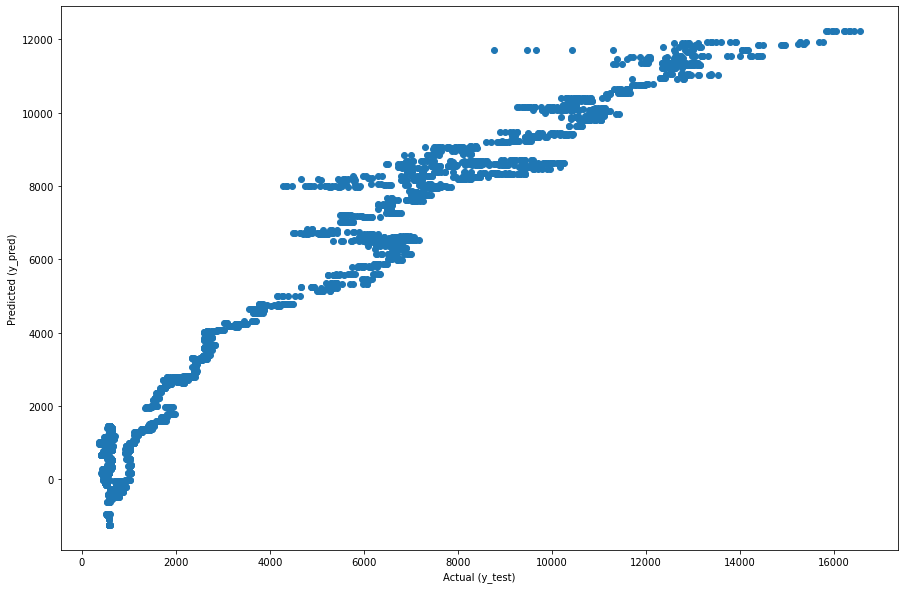

In [53]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,10))
plt.scatter(y_test, y_pred)
plt.xlabel('Actual (y_test)')
plt.ylabel('Predicted (y_pred)')

In [36]:
pred_y_df=pd.DataFrame({'y_test': y_test, 'y_pred': y_pred, 'Difference': y_test-y_pred})
pred_y_df.head(20)

,y_test,y_pred,Difference
825,618.559998,558.171549,60.388449
10846,5242.750000,8006.512940,-2763.762940
4137,655.469971,-302.782960,958.252931
13788,13324.870120,11546.249646,1778.620474
6180,2055.320068,2799.157006,-743.836938
11163,7257.620117,8389.440560,-1131.820443
10174,8145.529785,8393.422457,-247.892672
8976,6434.859863,6501.273254,-66.413391
368,541.059998,197.552602,343.507396
10057,7852.180176,7980.079157,-127.898981


# Export 

In [24]:
Model_df = pd.DataFrame(X_test,y_pred)
Model_df

,Inflation,Working_Pop,Real_GDP_per_Capita
558.171549,NaN,NaN,NaN
8006.512940,NaN,NaN,NaN
-302.782960,NaN,NaN,NaN
11546.249646,NaN,NaN,NaN
2799.157006,NaN,NaN,NaN
...,...,...,...
5873.898528,NaN,NaN,NaN
8541.462577,NaN,NaN,NaN
-959.426919,NaN,NaN,NaN
544.048136,NaN,NaN,NaN


In [25]:
X_train

,Inflation,Working_Pop,Real_GDP_per_Capita
13693,1.081754,2.073116e+08,83247.677088
2619,0.239645,9.691700e+07,62036.134012
2687,0.244286,9.691700e+07,62036.134012
12563,1.001346,2.047238e+08,85298.246974
200,0.138809,7.717800e+07,58289.408899
...,...,...,...
905,0.156529,8.224000e+07,60449.282588
5192,0.464946,1.534505e+08,53886.644754
12172,1.003725,2.029429e+08,83117.513173
235,0.138809,7.717800e+07,58289.408899


In [51]:
X_test

,Inflation,Working_Pop,Real_GDP_per_Capita
825,0.153576,8.224000e+07,60052.626459
10846,0.895265,1.973148e+08,76970.791112
4137,0.411363,1.470297e+08,46277.317745
13788,1.098605,2.058482e+08,91172.916401
6180,0.555234,1.599734e+08,58787.874559
...,...,...,...
8356,0.696153,1.746548e+08,71058.899525
11288,0.923153,1.999897e+08,79044.047937
3023,0.265382,1.378928e+08,45933.137165
1443,0.172562,8.692900e+07,59296.057702


In [29]:
y_pred.

array([ 558.17154944, 8006.51294047, -302.78295959, ..., -959.42691881,
        544.04813557, -414.77302741])